In [26]:
# Please install any missing dependencies before running the script.
# !pip3 install evaluate

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset
import evaluate

from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
import torch

In [28]:
df = pd.read_json("./Industrial_and_Scientific_5.json.gz", lines=True)

# Unnecessary Columns: reviewTime, style, reviewerName, unixReviewTime, image, vote
df = df.drop(["reviewTime", "style", "reviewerName", "unixReviewTime", "image", "summary", "vote"], axis=1)

df

,overall,verified,reviewerID,asin,reviewText
0,5,True,A1JB7HFWHRYHT7,B0000223SI,This worked really well for what I used it for...
1,5,True,A2FCLJG5GV8SD6,B0000223SI,Fast cutting and good adheasive.
2,5,False,A3IT9B33NWYQSL,B0000223SI,Worked great for my lapping bench. I would li...
3,4,True,AUL5LCV4TT73P,B0000223SK,As advertised
4,5,True,A1V3I3L5JKO7TM,B0000223SK,seems like a pretty good value as opposed to b...
...,...,...,...,...,...
77066,5,True,A1UZ9AVZFWZS1A,B01HCVJ3K2,So far it has worked like a champ. Great solut...
77067,5,True,A1PMSQXD43WIS4,B01HCVJ3K2,Great quality solid state relay. I used this s...
77068,5,True,A225WHD7XZVIXL,B01HEQVQAK,Came with everything needed to install in my M...
77069,5,True,A3T05FOORNQI18,B01HEQVQAK,Installed a month ago in my Monoprice Maker Se...


# Data Exploration

In [29]:
# Handle missing values
print(df.isna().sum())
df.dropna(subset=['reviewText'], inplace=True)

# Explore data stats
print('Counts:')
print(df.count(), '\n')
print('Averages:')
print(df.mean(numeric_only=True), '\n')
print('Medians:')
print(df.median(numeric_only=True), '\n')
print('Modes:')
print(df.mode(numeric_only=True).iloc[0], '\n')

overall        0
verified       0
reviewerID     0
asin           0
reviewText    11
dtype: int64
Counts:
overall       77060
verified      77060
reviewerID    77060
asin          77060
reviewText    77060
dtype: int64 

Averages:
overall     4.524046
verified    0.920257
dtype: float64 

Medians:
overall     5.0
verified    1.0
dtype: float64 

Modes:
overall        5
verified    True
Name: 0, dtype: object 



Number of reviews for each rating in the sample:
1     2481
2     1936
3     4442
4    12061
5    56140
Name: overall, dtype: int64


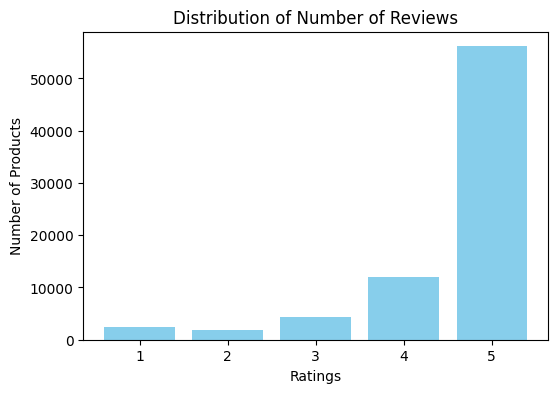

In [30]:
# Display distribution of the number of reviews across products
reviews_per_ratings = df.groupby('overall')['asin'].count()

review_counts = df['overall'].value_counts().sort_index()
print("Number of reviews for each rating in the sample:")
print(review_counts)

plt.figure(figsize=(6, 4))
plt.bar(reviews_per_ratings.index, reviews_per_ratings.values, color='skyblue')
plt.xlabel('Ratings')
plt.ylabel('Number of Products')
plt.title('Distribution of Number of Reviews')
plt.show()

In [31]:
# Distribution of the number of reviews per product
reviews_per_product = df.groupby(['asin', 'overall']).size().unstack(fill_value=0)
reviews_per_product['total_reviews'] = reviews_per_product.sum(axis=1)
print(reviews_per_product)

# Distribution of reviews per user
reviews_per_user = df.groupby(['reviewerID', 'overall']).size().unstack(fill_value=0)
reviews_per_user['total_reviews'] = reviews_per_user.sum(axis=1)
print(reviews_per_user)

overall     1  2  3   4   5  total_reviews
asin                                      
B0000223SI  0  0  0   1  12             13
B0000223SK  0  0  1   5  16             22
B0000223UV  1  0  2  10  24             37
B00002246J  0  0  1   6   9             16
B0000224J0  0  0  0   1  14             15
...        .. .. ..  ..  ..            ...
B01HCQSHNG  1  0  3   1   2              7
B01HCVJ3K2  0  0  0   1  23             24
B01HDXZR5E  1  0  0   3  13             17
B01HDYEAOW  0  0  0   0   5              5
B01HEQVQAK  0  0  0   3   6              9

[5334 rows x 6 columns]
overall               1  2  3  4   5  total_reviews
reviewerID                                         
A0096681Y127OL1H8W3U  0  0  0  0   5              5
A0196552RI15HI7JB9PW  0  0  0  0   5              5
A0289048PRWFY7ZXQKCD  0  0  2  7   0              9
A0455940O5EUXQDU46QL  0  0  1  2   4              7
A07936821FOVJO6NP4Q8  0  0  3  1   6             10
...                  .. .. .. ..  ..            ...


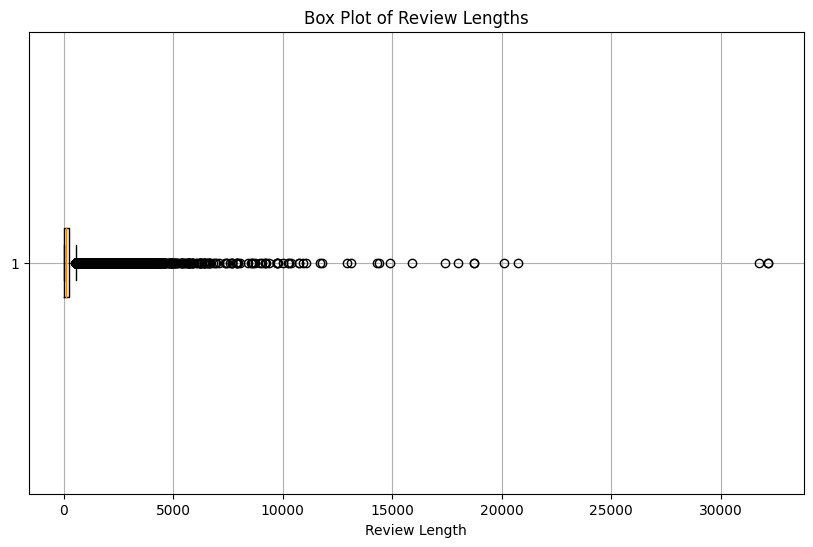

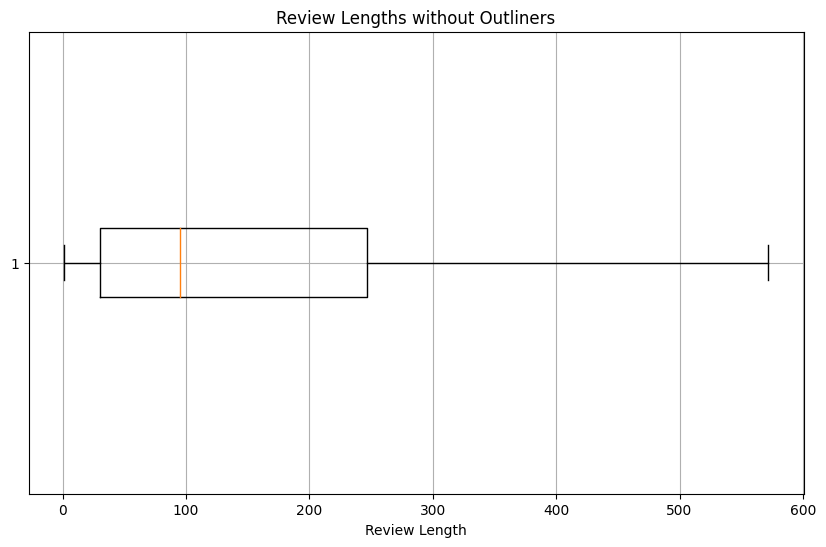

In [32]:
# Check outliners
df['review_length'] = df['reviewText'].apply(lambda x: len(x))

plt.figure(figsize=(10, 6))
plt.boxplot(df['review_length'], vert=False)
plt.title('Box Plot of Review Lengths')
plt.xlabel('Review Length')
plt.grid(True)
plt.show()

# Display length of review without outliner
plt.figure(figsize=(10, 6))
plt.boxplot(df['review_length'], vert=False, showfliers=False)
plt.title('Review Lengths without Outliners')
plt.xlabel('Review Length')
plt.grid(True)
plt.show()

In [33]:
# Analyze lengths
print("Descriptive Statistics of Review Length:")
print(df['review_length'].describe())

# Check for duplicates
df_review = df["reviewText"]
duplicate_rows = df_review.duplicated()
num_duplicates = duplicate_rows.sum()
duplicate_data = df_review[duplicate_rows]
print("There are", num_duplicates, "duplicate rows in the dataset.")
print(duplicate_data)

print("Drop Duplicates")
df.drop_duplicates(subset=['reviewText'], inplace=True)
num_duplicates = df.duplicated().sum()
print("There are", num_duplicates, "duplicate rows in the dataset.")

Descriptive Statistics of Review Length:
count    77060.000000
mean       241.052232
std        558.087584
min          1.000000
25%         30.000000
50%         95.000000
75%        247.000000
max      32184.000000
Name: review_length, dtype: float64
There are 18730 duplicate rows in the dataset.
11       This stuff is great. Adhesive on the back and ...
24       As a hobbyist, I frequently need to sand the s...
29       I have been using this all week with a sanding...
68       "Gorilla Glue" has become one of the most used...
69       "Gorilla Glue" has become one of the most used...
                               ...                        
77038                                            It works.
77045    I find this PLA to be on par with Polymaker's ...
77049                                           good price
77052                                           Great item
77053                                  Great for the price
Name: reviewText, Length: 18730, dtype: object
Drop

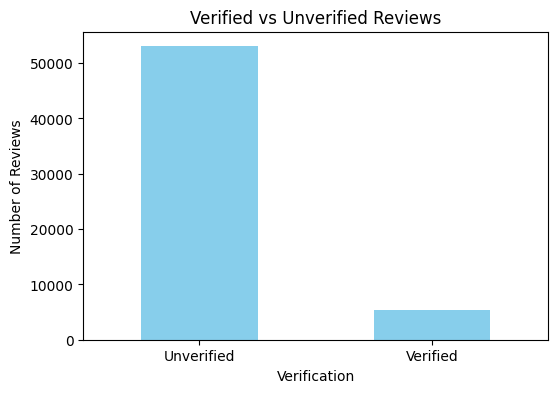

In [34]:
# Verified vs Unverified reviews analysis
verified_counts = df['verified'].value_counts()
plt.figure(figsize=(6, 4))
verified_counts.plot(kind='bar', color='skyblue')
plt.title('Verified vs Unverified Reviews')
plt.xlabel('Verification')
plt.ylabel('Number of Reviews')
plt.xticks(ticks=[0, 1], labels=['Unverified', 'Verified'], rotation=0)
plt.show()

# Data Preprocessing

## Outlier Removal

(52855, 6)


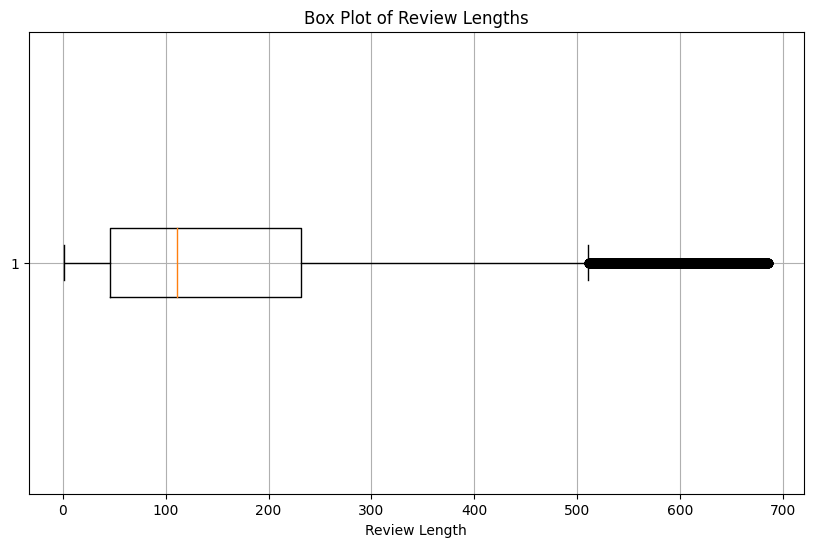

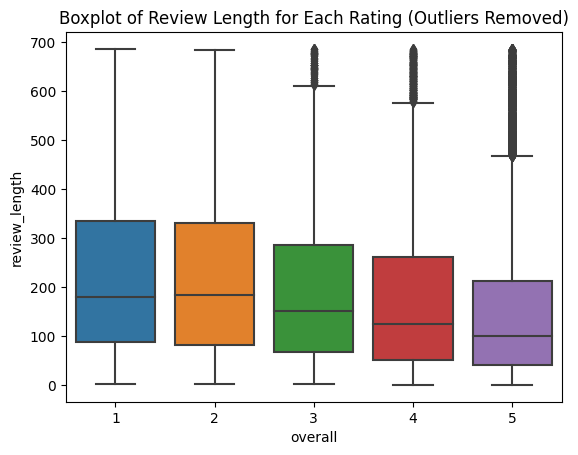

In [35]:
# Outlier Removal using IQR method
Q1 = df['review_length'].quantile(0.25)
Q3 = df['review_length'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['review_length'] >= lower_bound) & (df['review_length'] <= upper_bound)]
print(df.shape)

plt.figure(figsize=(10, 6))
plt.boxplot(df['review_length'], vert=False)
plt.title('Box Plot of Review Lengths')
plt.xlabel('Review Length')
plt.grid(True)
plt.show()

sns.boxplot(x='overall', y='review_length', data=df)
plt.title('Boxplot of Review Length for Each Rating (Outliers Removed)')
plt.show()

## Data Transformation

In [36]:
df['overall'] = df['overall'].replace({1: 0, 
                                       2: 0, 
                                       3: 1, 
                                       4: 2, 
                                       5: 2})
set(df['overall'])

/var/folders/7z/m8630rps50j_2c9t_zhzgj6w0000gn/T/ipykernel_55706/1810583349.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['overall'] = df['overall'].replace({1: 0,


{0, 1, 2}

## Random Sampling

In [37]:
df_sample = df.sample(n=1000, random_state=2024)
df_sample = df_sample[['reviewText', 'overall']]
df_train, df_val = train_test_split(df_sample, test_size=0.1, random_state=42)

test_df = df[~df.index.isin(df_sample.index)]
test_df_sample = test_df.sample(n=1000, random_state=2024)
df_test = test_df_sample[['reviewText', 'overall']]

## Tokenization

In [38]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [39]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize(batch):
    tokenized_inputs = tokenizer(batch['reviewText'], padding=True, truncation=True, max_length=128, return_tensors='pt')
    tokenized_inputs["labels"] = torch.tensor(batch['overall'])
    return tokenized_inputs

train_dataset = Dataset.from_pandas(df_train).map(tokenize, batched=True)
val_dataset = Dataset.from_pandas(df_val).map(tokenize, batched=True)
test_dataset = Dataset.from_pandas(df_test).map(tokenize, batched=True)

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

# Model Fine-Tuning

In [40]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(np.unique(df['overall']))
)

model.to(mps_device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

metric = evaluate.load("accuracy")

def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=-1)
    
    # Compute accuracy
    accuracy = accuracy_score(labels, preds)
    
    # Compute precision, recall, and F1-score
    macro_precision = precision_score(labels, preds, average='macro')
    macro_recall = recall_score(labels, preds, average='macro')
    macro_f1 = f1_score(labels, preds, average='macro')
    
    return {
        "accuracy": accuracy,
        "precision": macro_precision,
        "recall": macro_recall,
        "f1_score": macro_f1
    }

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [42]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.4111839234828949, 'eval_accuracy': 0.86, 'eval_precision': 0.463768115942029, 'eval_recall': 0.4466089466089466, 'eval_f1_score': 0.45095693779904306, 'eval_runtime': 1.0111, 'eval_samples_per_second': 98.905, 'eval_steps_per_second': 12.858, 'epoch': 1.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.3106771409511566, 'eval_accuracy': 0.87, 'eval_precision': 0.5189393939393939, 'eval_recall': 0.4769119769119769, 'eval_f1_score': 0.49326805385556916, 'eval_runtime': 0.9815, 'eval_samples_per_second': 101.883, 'eval_steps_per_second': 13.245, 'epoch': 2.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.3400612771511078, 'eval_accuracy': 0.88, 'eval_precision': 0.6153679653679655, 'eval_recall': 0.5435786435786435, 'eval_f1_score': 0.569681309216193, 'eval_runtime': 0.9894, 'eval_samples_per_second': 101.066, 'eval_steps_per_second': 13.139, 'epoch': 3.0}
{'train_runtime': 136.0089, 'train_samples_per_second': 19.852, 'train_steps_per_second': 2.492, 'train_loss': 0.3585879795670861, 'epoch': 3.0}


TrainOutput(global_step=339, training_loss=0.3585879795670861, metrics={'train_runtime': 136.0089, 'train_samples_per_second': 19.852, 'train_steps_per_second': 2.492, 'train_loss': 0.3585879795670861, 'epoch': 3.0})

## Prediction Accuracy

In [43]:
predictions = trainer.predict(test_dataset)
print(predictions.predictions.shape, predictions.label_ids.shape)

eval_metrics = compute_metrics((predictions.predictions, predictions.label_ids))
print("Accuracy:", eval_metrics["accuracy"])
print("Macro Precision:", eval_metrics["precision"])
print("Macro Recall:", eval_metrics["recall"])
print("Macro F1 Score:", eval_metrics["f1_score"])

  0%|          | 0/125 [00:00<?, ?it/s]

(1000, 3) (1000,)
Accuracy: 0.9
Macro Precision: 0.6205008601296811
Macro Recall: 0.5330246913580247
Macro F1 Score: 0.5656383829322795
